# HLCM Diagnostic


Arezoo Besharati, Paul Waddell, UrbanSim, July 2018 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preliminaries</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Perform-desired-variable-creations-and-transformations" data-toc-modified-id="Perform-desired-variable-creations-and-transformations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Perform desired variable creations and transformations</a></span></li></ul></li><li><span><a href="#Model-Estimation" data-toc-modified-id="Model-Estimation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Estimation</a></span><ul class="toc-item"><li><span><a href="#HLCM-for-Multi-Family" data-toc-modified-id="HLCM-for-Multi-Family-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>HLCM for Multi-Family</a></span></li></ul></li><li><span><a href="#Model-Prediction" data-toc-modified-id="Model-Prediction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Prediction</a></span></li></ul></div>

## Preliminaries

In [1]:
import os; os.chdir('../../')
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import warnings;
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2

from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import seaborn as sns
%matplotlib notebook
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Load data

In [2]:
# Load any script-based Orca registrations
from scripts import datasources
from scripts import models

In [ ]:
## Initialize Networks
#orca.run(["initialize_network_walk","initialize_network_small"]);

### Perform desired variable creations and transformations

In [3]:
### Data Cleaning

parcel = orca.get_table('parcels').to_frame()
bld = orca.get_table('buildings').to_frame()
hh = orca.get_table('households').to_frame()

hh['hh_random'] = np.random.uniform(0,1,len(hh))
nodeswalk = orca.get_table('nodeswalk').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()

nodessmall_upper = nodessmall.quantile(.99)
nodessmall_clipped = nodessmall.clip_upper(nodessmall_upper, axis=1) 
nsc=nodessmall_clipped

nodeswalk_upper = nodeswalk.quantile(.99)
nodeswalk_clipped = nodeswalk.clip_upper(nodeswalk_upper, axis=1) 
nwc=nodeswalk_clipped


# scale income and create race dummies
hh.income_k = hh.income/1000
hh.white = (hh.race_of_head == 1).astype(int)
hh.black = (hh.race_of_head == 2).astype(int)
hh.asian = (hh.race_of_head == 6).astype(int)
hh.hisp = (hh.hispanic_head == 'yes').astype(int)
hh.single = (hh.persons == 1).astype(int)
hh.elderly = (hh.age_of_head > 65).astype(int)


# building_type dummies
bld.single_family = (bld.building_type_id == 1).astype(int)
bld.multi_family = (bld.building_type_id == 3).astype(int)
bld.mixed_use = (bld.building_type_id > 3).astype(int)

# add the columns

orca.add_column('households', 'income_k', hh.income_k)
orca.add_column('households', 'white', hh.white)
orca.add_column('households', 'black', hh.black)
orca.add_column('households', 'asian', hh.asian)
orca.add_column('households', 'hispanic', hh.hisp)
orca.add_column('households', 'elderly', hh.elderly)
orca.add_column('households', 'single', hh.single)
orca.add_column('households', 'hh_random', hh.hh_random)

orca.add_column('buildings', 'single_family', bld.single_family)
orca.add_column('buildings', 'multi_family', bld.multi_family)
orca.add_column('buildings', 'mixed_use', bld.mixed_use);

nwc['prop_children_500_walk'] = (nwc['children_500_walk'] > 0).astype(int) / nwc['hh_500_walk']
nwc['prop_singles_500_walk'] = nwc['singles_500_walk'] / nwc['hh_500_walk']
nwc['prop_elderly_500_walk'] = nwc['elderly_hh_500_walk'] / nwc['hh_500_walk']
nwc['prop_black_500_walk'] = nwc['pop_black_500_walk'] / nwc['pop_500_walk']
nwc['prop_white_500_walk'] = nwc['pop_white_500_walk'] / nwc['pop_500_walk']
nwc['prop_asian_500_walk'] = nwc['pop_asian_500_walk'] / nwc['pop_500_walk']
nwc['prop_hisp_500_walk'] = nwc['pop_hisp_500_walk'] / nwc['pop_500_walk']
nwc['prop_rich_500_walk'] = nwc['rich_500_walk'] / nwc['pop_500_walk']
nwc['prop_poor_500_walk'] = nwc['poor_500_walk'] / nwc['pop_500_walk']

nwc['prop_children_1500_walk'] = (nwc['children_1500_walk'] > 0).astype(int) / nwc['hh_1500_walk']
nwc['prop_singles_1500_walk'] = nwc['singles_1500_walk'] / nwc['hh_1500_walk']
nwc['prop_elderly_1500_walk'] = nwc['elderly_hh_1500_walk'] / nwc['hh_1500_walk']
nwc['prop_black_1500_walk'] = nwc['pop_black_1500_walk'] / nwc['pop_1500_walk']
nwc['prop_white_1500_walk'] = nwc['pop_white_1500_walk'] / nwc['pop_1500_walk']
nwc['prop_asian_1500_walk'] = nwc['pop_asian_1500_walk'] / nwc['pop_1500_walk']
nwc['prop_hisp_1500_walk'] = nwc['pop_hisp_1500_walk'] / nwc['pop_1500_walk']
nwc['prop_rich_1500_walk'] = nwc['rich_1500_walk'] / nwc['pop_1500_walk']
nwc['prop_poor_1500_walk'] = nwc['poor_1500_walk'] / nwc['pop_1500_walk']

orca.add_table('nodessmall', nsc);
orca.add_table('nodeswalk', nwc);

In [4]:
hh_f = hh[(hh['building_type'] > 2) & (hh['hh_random'] < .2) & (hh['recent_mover'] == 1) \
        & (hh['income'] > 0) & (hh['income'] < 500000)]
len(hh_f)

15342

In [5]:
mm.initialize()

Loading model step 'hedonic_price_sqft_multi_family'
Loading model step 'hedonic_price_sqft_single_family'
Loading model step 'hedonic_rent_sqft'
Loading model step 'hlcm'
Loading model step 'hlcm_multi_family'
Loading model step 'hlcm_multi_family2'
Loading model step 'hlcm_multi_family3'


## Model Estimation

### HLCM for Multi-Family 

In [7]:
orca.broadcast('nodeswalk', 'rentals', cast_index=True, onto_on='node_id_walk')
orca.broadcast('nodeswalk', 'parcels', cast_index=True, onto_on='node_id_walk')
orca.broadcast('nodessmall', 'rentals', cast_index=True, onto_on='node_id_small')
orca.broadcast('nodessmall', 'parcels', cast_index=True, onto_on='node_id_small')


In [8]:
%%time
m_mf = LargeMultinomialLogitStep()
m_mf.choosers = ['households']
m_mf.alternatives = ['buildings','parcels','nodeswalk','nodessmall']
m_mf.choice_column = 'building_id'
m_mf.alt_sample_size = 50

#Filters on choosers
# m_mf2.chooser_filters = ['building_type > 2 &\
#                           household_id % 1000 < 40 &\
#                           recent_mover == 1 &\
#                           0 <income < 500000']


m_mf.chooser_filters = ['building_type > 2 &\
                          hh_random < .2 &\
                          recent_mover == 1 &\
                          0 <income < 500000']


#Filters on alternatives
m_mf.alt_filters = ['residential_units > 1',
                     '0 < avg_income_500_walk < 300000',
                     'pop_1500_walk > 0',
                     'sqft_per_unit > 0']


m_mf.model_expression = ' np.log(residential_units) + \
np.log1p(res_price_per_sqft) + \
np.log1p(sqft_per_unit) + \
np.log1p(income):np.log1p(sqft_per_unit) + \
np.log1p(jobs_1500_walk) + \
np.log1p(jobs_25000) + \
np.log(income):np.log(avg_income_1500_walk) + \
np.log1p(pop_1500_walk) + \
white:prop_white_500_walk + \
black:prop_black_500_walk + \
asian:prop_asian_500_walk + \
hispanic:prop_hisp_500_walk\
- 1'


m_mf.name = 'hlcm_multi_family1'
m_mf.tags = ['multi_family','test']
m_mf.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          9,308
Model:         Multinomial Logit   Df Residuals:              9,296
Method:       Maximum Likelihood   Df Model:                     12
Date:                 2018-07-22   Pseudo R-squ.:             0.375
Time:                      14:38   Pseudo R-bar-squ.:         0.375
AIC:                  45,511.933   Log-Likelihood:      -22,743.967
BIC:                  45,597.597   LL-Null:             -36,413.110
                                                 coef   std err         z     P>|z|   Conf. Int.
------------------------------------------------------------------------------------------------
np.log(residential_units)                      1.2151     0.008   147.737     0.000             
np.log1p(res_price_per_sqft)                  -0.1608     0.011   -14.273     0.000             
np.log1p(sqft_per_unit)                       -0.7826     0.043   -1

In [9]:
# register the model
m_mf.register()

Saving 'hlcm_multi_family1.yaml': /Users/arezoobzadeh/Documents/GitHub/urbansim_parcel_bayarea/configs
Loading model step 'hlcm_multi_family1'


In [10]:
# number of choosers/agents/households/observations
len(m_mf._get_df(tables=m_mf.choosers, filters=m_mf.chooser_filters))

15342

In [11]:
m_mf.fitted_parameters
#or
#mm.get_step('hlcm_multi_family').fitted_parameters

[1.2150999073602415,
 -0.16081622246026797,
 -0.7825795754393018,
 0.0714622787597452,
 0.2434416214238759,
 0.06402322789622927,
 0.016778754292451577,
 -0.18234191605050132,
 1.3876137582109558,
 7.651173070079466,
 2.7973369228007776,
 3.8742339624404214]

## Model Prediction

In [12]:
m_mf.out_chooser_filters = ['building_type > 2 &\
                          hh_random < .2 &\
                          recent_mover == 1 &\
                          0 <income < 500000']

m_mf.out_alt_filters = ['residential_units == 1',
                         '0 < avg_income_500_walk < 500000',
                         'sqft_per_unit > 0']

In [13]:
%%time
m_mf.run()

CPU times: user 31.2 s, sys: 14.9 s, total: 46.1 s
Wall time: 37.3 s


In [14]:
print(m_mf.probabilities.shape)
m_mf.probabilities.head()

(767100, 3)


,observation_id,building_id,probability
0,169,887036,0.01
1,169,1751818,0.01
2,169,1488525,0.03
3,169,411583,0.01
4,169,584129,0.01


In [15]:
### number of observations/choosers
print(len(m_mf.probabilities.observation_id.unique()))
### or 
#len(m_mf.choices)

### number of unique alternatives
print(len(m_mf.probabilities.building_id.unique()))

### number of alternatives
print(len(m_mf.probabilities.building_id))

15342
533588
767100


In [16]:
# summed probability 

predict_df=m_mf.probabilities.groupby('building_id')['probability'].sum().to_frame()
predict_df.head()

,probability
building_id,
3,0.01
7,0.16
378,0.01
383,0.01
418,0.02


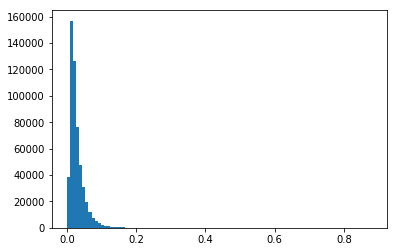

In [20]:
plt.hist(predict_df['probability'],bins= 100);


In [ ]:
# Check that choices are plausible
choices = pd.DataFrame(m_mf.choices)
df = pd.merge(m_mf.probabilities, choices, left_on='observation_id', right_index=True)
df['chosen'] = 0
df.loc[df.building_id == df.choice, 'chosen'] = 1
print(df.head())

In [ ]:
print(np.corrcoef(df.probability, df.chosen))

In [ ]:
### join predicted df and df 
#hh_f = hh[(hh['building_type'] > 2) & (hh['hh_random'] < .2) & (hh['recent_mover'] == 1)\
#        & (hh['income'] > 0) & (hh['income'] < 500000)]
             
#df = orca.merge_tables(target = 'buildings', tables = ['buildings','parcels','nodeswalk','nodessmall'])
  
#hh_f_data = hh_f.merge(df, left_on='building_id', right_index=True)
#hh_f_data.columns.tolist()

#predict= pd.merge(predict_df,hh_f_data, left_index=True,right_on='building_id',how='left', sort=False)
#predict[['probability','building_id']].head()

#predict_2= pd.merge(predict_df,df, left_index=True,right_index=True,how='left', sort=False)
#predict_2.head()